# Variance Estimation: Postprocessing

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorboard as tb
import tensorboard.data_compat
import tensorflow as tf

In [2]:
from pathlib import Path
from typing import List, Optional

First of all, define some globals.

In [212]:
METRICS = {'eval/accuracy', 'eval/matthews_correlation', 'eval/pearson'}
COUNTER = {'train/train_runtime'}

In [47]:
def convert(srcs: List[Path], dst: Optional[Path] = None) -> pd.DataFrame:
    """Function convert reads TensorBoard (written by HuggingFace transformers
    library), filters it contents, and write it to CSV file.
    """
    records = []
    for i, el in enumerate(tf.data.TFRecordDataset(srcs)):
        event = tb.compat.proto.event_pb2.Event.FromString(el.numpy())
        event = tb.data_compat.migrate_event(event)
        if event.summary is None:
            continue
        for value in event.summary.value:
            prefix, _ = value.tag.split('/', 1)
            if prefix not in ('eval', 'train'):
                continue
            records.append((event.step, value.tag, value.tensor.float_val[0]))

    df = pd.DataFrame(data=records, columns=('step', 'tag', 'value'))
    df = df.set_index(['tag', 'step'])
    df = df.sort_index()
    if dst:
        df.to_csv(dst)
    return df

In [381]:
root = Path('../../')

Read all TensorBoard logs.

In [402]:
frames = []
for matmul in map(Path, ['dct', 'dft', 'gauss', 'rademacher']):
    dirname = root / 'log' / matmul
    filenames = !find -L "$dirname" -mindepth 1 -maxdepth 3 -type f -printf "%P\n"
    for filename in filenames:
        param, task, _ = filename.split('/', 2)
        path = dirname / filename
        frame = convert(path)
        frame = frame.reset_index()
        frame['matmul'] = str(matmul)
        frame['task'] = task.upper()
        frame['param'] = param
        frames.append(frame)

In [403]:
df = pd.concat(frames) \
    .set_index(['task', 'param', 'tag', 'step']) \
    .sort_index() \
    .reset_index()

In [404]:
df = df[df.param.isin({'10', '20', '50', 'baseline'})]

## Time

In [405]:
times = df[df.tag.isin(COUNTER)]
times = times \
    .set_index(['task', 'matmul', 'param']) \
    .groupby(level=[0, 1, 2])[['value']] \
    .max()

In [406]:
frame = times.loc['COLA'].reset_index()
frame_baseline = frame[frame.param == 'baseline'].copy()
frame_baseline['matmul'] = 'No RMM'
frame_baseline = frame_baseline \
    .groupby('matmul') \
    .agg({'param': 'first', 'value': 'mean'}) \
    .reset_index() \
    .set_index(['matmul', 'param'])
frame_rmm = frame[frame.param != 'baseline'].copy()
frame_rmm = frame_rmm \
    .set_index(['matmul', 'param']) \
    .sort_index()
frame = pd.concat([frame_baseline, frame_rmm])
frame['value'] = pd.to_timedelta(frame.value, unit='s')
frame['time'] = frame \
    .value.dt.components \
    .apply(lambda x: f'{x.minutes:02d}:{x.seconds:02d}', axis=1)
frame = frame[['time']]

In [407]:
rhs = frame

### Score

In [408]:
perf = df[df.tag.isin(METRICS)]
perf = perf \
    .set_index(['task', 'matmul', 'param']) \
    .groupby(level=[0, 1, 2])[['value']] \
    .max()

In [409]:
frame = perf.loc['COLA'].reset_index()
frame_baseline = frame[frame.param == 'baseline'].copy()
frame_baseline['matmul'] = 'No RMM'
frame_baseline = frame_baseline \
    .groupby('matmul') \
    .agg({'param': 'first', 'value': 'mean'}) \
    .reset_index() \
    .set_index(['matmul', 'param'])
frame_rmm = frame[frame.param != 'baseline'].copy()
frame_rmm = frame_rmm \
    .set_index(['matmul', 'param']) \
    .sort_index()
frame = pd.concat([frame_baseline, frame_rmm])
frame['score'] = (100 * frame.value).round(2)
frame = frame[['score']]

In [410]:
lhs = frame

In [411]:
tbl = pd.merge(lhs, rhs, left_index=True, right_index=True)

In [412]:
MDASH = '—'

In [413]:
def format_param(value: str) -> str:
    if value == 'baseline':
        return f'{MDASH:^5s}'
    else:
        return f'{float(int(value)):.0f}%'
    

def format_matmul(value: str) -> str:
    if value.lower() in ('no rmm', 'baseline'):
        return 'No RMM'
    elif value.lower() in ('dct', 'dft'):
        return value.upper()
    elif value in ('gauss', 'kroneker', 'rademacher'):
        return value.capitalize()

In [414]:
tbl = tbl \
    .sort_index(ascending=[True, False]) \
    .reset_index() \
    .dropna()
tbl['param'] = tbl.param.apply(format_param)

In [415]:
tbl['matmul'] = tbl.matmul.apply(format_matmul)

In [416]:
tbl.columns = ['MatMul', 'Rate', 'Score', 'Time, min']

In [417]:
tbl = tbl.set_index(['MatMul', 'Rate'])

In [418]:
tbl

Score Time, min
MatMul     Rate                  
No RMM       —    60.90     08:44
DCT        50%    59.17     16:26
           20%    58.81     16:37
           10%    53.38     17:24
DFT        50%    59.05     12:20
           20%    60.60     11:42
           10%    47.62     12:25
Gauss      50%    58.60     10:36
           20%    57.79     10:02
           10%    56.52     10:03
Rademacher 50%    62.38     15:27
           20%    59.11     15:38
           10%    55.50     15:43

In [419]:
tbl.to_latex(buf='../../doc/randomized-backward/tbl/matmul-comparison.tex', column_format='llrr')

Select neccesary columns and filter rows by metric name.

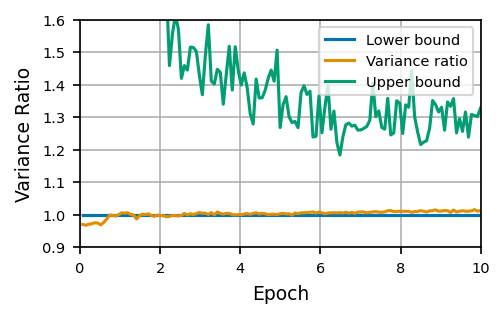

In [496]:
with mpl.rc_context({
        'backend': 'pgf',
        'figure.dpi': 150,
        **bundles.icml2022(column='half', nrows=1),
}):
    fig, ax = plt.subplots()

    ax.plot(lb.step / nosteps, lb.value, label='Lower bound')
    ax.plot(ratio.step / nosteps , ratio.value, label='Variance ratio')
    ax.plot(ub.step / nosteps, ub.value, label='Upper bound')
    ax.legend(loc='upper right')
    ax.grid()
    ax.set_xlim(0, 10)
    ax.set_ylim(ymin=0.9, ymax=1.6)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Variance Ratio')
    
    fig.savefig('../doc/randomized-backward/fig/variance-ratio.pgf')